## Train a VAE on MNIST

In [1]:
a = 5

,run_count,epoch,kl_loss,data_fidelity,beta,batch_size,lr,device,z_dim
0,1,0,0.081383,0.718629,10,128,0.0005,cuda,9
1,1,1,0.176329,0.707284,10,128,0.0005,cuda,9
2,1,2,0.295534,0.698093,10,128,0.0005,cuda,9
3,1,3,0.411564,0.684660,10,128,0.0005,cuda,9
4,1,4,0.529738,0.672387,10,128,0.0005,cuda,9
...,...,...,...,...,...,...,...,...,...
95,1,95,11.204289,0.267347,10,128,0.0005,cuda,9
96,1,96,11.320701,0.265780,10,128,0.0005,cuda,9
97,1,97,11.437424,0.264452,10,128,0.0005,cuda,9
98,1,98,11.551809,0.263665,10,128,0.0005,cuda,9


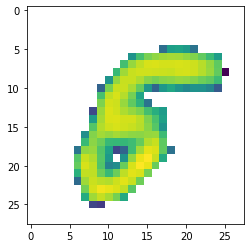

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
from models.vae import BetaVAE
import matplotlib.pyplot as plt
from dataset import MNISTDataset, MNIST_mean, MNIST_std


class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.0005],
    batch_size = [128],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    beta = [10],
    z_dim = [9], 
    manual_seed = [1265],
    loss_type = ['B']
)

train_set = MNISTDataset(path='data/MNIST/processed', normalize=True)


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0
for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    model = BetaVAE(
                    latent_dim=run.z_dim,
                    beta=run.beta,
                   loss_type=run.loss_type)
    model = model.to(device)
    loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle, num_workers=run.num_workers)
    optimizer = torch.optim.Adam(model.parameters(), lr=run.lr)

    num_batches = len(train_set)/run.batch_size
    for epoch in range(100):

        total_kl_loss = 0
        total_recons_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['kl_loss'] = total_kl_loss/num_batches
        results['data_fidelity'] = total_recons_loss/num_batches
        results['beta'] = run.beta
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        results['z_dim'] = run.z_dim
        
#         run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        
     
        for batch in tqdm(loader):
            batch_count +=1
#             print('data loading time', time.time() - data_load_time)
            optimizer.zero_grad()
#             forward_time = time.time()
            X= batch
            X = X.to(device=run.device)
            out = model(X)
#             print('forward  time', time.time() - forward_time)
            
            losses = model.loss_function(*out,
                                         M_N = run.batch_size/len(train_set))
            losses['loss'].backward()
            optimizer.step()
            
#             print(' backward time', time.time() - forward_time)
            total_kl_loss += losses['KLD'].item()
            total_recons_loss += losses['Reconstruction_Loss'].item()
            
#             data_load_time = time.time()
            if batch_count % 100 ==0:
                clear_output(wait=True)
                display(df2)
                sample = model.sample(1, device)
                sample = sample.to('cpu')
                plt.imshow(torch.log(sample+1e-16).detach().squeeze().numpy())
                plt.show()
            
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['kl_loss'] = total_kl_loss/num_batches
        results['data_fidelity'] = total_recons_loss/num_batches
        results['beta'] = run.beta
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        results['z_dim'] = run.z_dim
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df2)
        sample = model.sample(1, device)
        sample = sample.to('cpu')
        plt.imshow(torch.log(sample+1e-16).detach().squeeze().numpy())
        plt.show()

        torch.save(model, 'trained_models/vae_jun7_z_9.model'.format(run.lr,run.beta, run.z_dim))
    models.append(model)

In [ ]:
torch.tensr